In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2)))
suppressPackageStartupMessages(suppressWarnings(library(argparse)))
suppressPackageStartupMessages(suppressWarnings(library(dplyr)))
suppressPackageStartupMessages(suppressWarnings(library(cowplot)))
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer)))
suppressPackageStartupMessages(suppressWarnings(library(patchwork)))
suppressPackageStartupMessages(suppressWarnings(library(tidyr)))

# load in theme
source("../../utils/figure_themes.r")

In [2]:
cell_type <- "PBMC"

In [3]:
# make the figures directory if it doesn't exist
if (!dir.exists("../figures")) {
    dir.create("../figures")
}
redundancy_index_plot_not_shuffled_path <- file.path(paste0(
    "../", 
    "figures/",
    cell_type,
    "_redundancy_index_not_shuffled_plot.png"))

redundancy_index_plot_shuffled_path <- file.path(paste0(
    "../", 
    "figures/",
    cell_type,
    "_redundancy_index_shuffled_plot.png"))

# import data
redundancy_file_path <- file.path(paste0(
    "../", 
    "../",
    "../",
    "7.redundancy_analysis/",
    "results/",
    cell_type,
    "_redundancy_analysis.csv"))

redundancy_df <- read.csv(redundancy_file_path)
head(redundancy_df)

,RI_u,RI_v,u_k,v_k,r2,Shuffle,global_RI_u,global_RI_v,global_RI_u_v,global_min,global_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-26.57856,-268.4791,0.0009070606,0.009162529,-29301.85,True,7.360501,92.6395,-52737.39,-1498.675,-23.53563
2,-26.04870,-794.6672,0.0008889779,0.027120032,-29301.85,True,7.360501,92.6395,-52737.39,-1498.675,-23.53563
3,-27.13976,-316.8790,0.0009262132,0.010814299,-29301.85,True,7.360501,92.6395,-52737.39,-1498.675,-23.53563
4,-26.40765,-754.9614,0.0009012281,0.025764972,-29301.85,True,7.360501,92.6395,-52737.39,-1498.675,-23.53563
5,-26.61751,-278.7562,0.0009083900,0.009513262,-29301.85,True,7.360501,92.6395,-52737.39,-1498.675,-23.53563
6,-26.39175,-934.6497,0.0009006854,0.031897290,-29301.85,True,7.360501,92.6395,-52737.39,-1498.675,-23.53563


In [4]:
unique(redundancy_df$Shuffle)

[1] "True"  "False"

### Plot of Redundancy Index

In [5]:
# change True to Shuffled data via mutate
redundancy_df <- redundancy_df %>% mutate(Shuffle = ifelse(Shuffle == "True", "Shuffled", "Not Shuffled"))
minimum_value <- min(redundancy_df$RI_u, redundancy_df$RI_v)
maximum_value <- max(redundancy_df$RI_u, redundancy_df$RI_v)
# shuffle = True df
shuffle_df <- redundancy_df[redundancy_df$Shuffle == "Shuffled",]
shuffle_min <- min(shuffle_df$RI_u, shuffle_df$RI_v)
shuffle_max <- max(shuffle_df$RI_u, shuffle_df$RI_v)
# shuffle = False df
no_shuffle_df <- redundancy_df[redundancy_df$Shuffle == "Not Shuffled",]
no_shuffle_min <- min(no_shuffle_df$RI_u, no_shuffle_df$RI_v)
no_shuffle_max <- max(no_shuffle_df$RI_u, no_shuffle_df$RI_v)


In [6]:
# linear model the shuffled and not shuffled data
non_shuffled_lm <- lm(RI_v ~ RI_u, data = no_shuffle_df)
non_shuffled_lm_summary <- summary(non_shuffled_lm)
non_shuffled_slope <- as.data.frame(non_shuffled_lm_summary$coefficients)$Estimate[2]
non_shuffled_intercept <- as.data.frame(non_shuffled_lm_summary$coefficients)$Estimate[1]

shuffled_lm <- lm(RI_v ~ RI_u, data = shuffle_df)
shuffled_lm_summary <- summary(shuffled_lm)
shuffled_slope <- as.data.frame(shuffled_lm_summary$coefficients)$Estimate[2]
shuffled_intercept <- as.data.frame(shuffled_lm_summary$coefficients)$Estimate[1]

In [7]:
# set cutoff for axis break
yticks_shuffle <- c(-1000,-100,-50,-10)
# function to transform data to y position
trans <- function(x){pmin(x,40) + 0.05*pmax(x-40,0)}

### shuffled data plot

In [8]:
RI_plot_inset_shuffle <- (
    ggplot(shuffle_df, aes(x=RI_u, y=RI_v, color=Shuffle))
    + geom_point()
    + theme_bw()
    + xlim(shuffle_min, shuffle_max)
    + ylim(shuffle_min, shuffle_max)
    + ggtitle("Shuffled Data")
    + xlab("Morphology RI")
    + ylab("nELISA RI")
    + geom_abline(intercept = 0, slope = 1, linetype="dashed", color="black")
    + figure_theme

    + theme(
        plot.title = element_text(size = 20, hjust = 0.5)
    )

)

In [9]:
RI_plot_w_inset <- (
    ggplot(shuffle_df, aes(x=RI_u, y=RI_v, color=Shuffle))
    + geom_point()
    + theme_bw()
    + xlim(-50, shuffle_max)
    + ylim(-600, shuffle_max)
    + geom_abline(intercept = 0, slope = 1, linetype="dashed", color="black")
    + figure_theme

    + theme(
        plot.title = element_text(size = 20, hjust = 0.5)
    )
)
# drop legend
RI_plot_inset_shuffle <- RI_plot_inset_shuffle + theme(legend.position = "none")+ ggplot2::coord_fixed()
# drop axis labels
RI_plot_w_inset <- RI_plot_w_inset + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
RI_plot_w_inset <- RI_plot_w_inset + theme(legend.position = "none")+ ggplot2::coord_fixed()
# shuffle_inset_full <- (
#   ggdraw() 
#   + draw_plot(RI_plot_inset_shuffle)
#   + draw_plot(RI_plot_w_inset, x = 0.12, y = 0.57, width = 0.3, height = 0.3)
#   + ggplot2::coord_fixed()
# )

ggsave(redundancy_index_plot_shuffled_path, width = 8, height = 8)


Warning message:
“Removed 11 rows containing missing values (`geom_point()`).”


### non shuffled data plot

In [10]:
RI_plot_no_shuffle <- (
    ggplot(no_shuffle_df, aes(x=RI_u, y=RI_v, color=Shuffle))
    + geom_point()
    + theme_bw()
    + xlim(no_shuffle_min, no_shuffle_max)
    + ylim(no_shuffle_min, no_shuffle_max)
    + ggtitle("Non-Shuffled Data")
    + xlab("Morphology RI")
    + ylab("nELISA RI")
    + geom_abline(intercept = 0, slope = 1, linetype="dashed", color="black")
    # change color of points to blue
    + scale_color_manual(values = c("blue"))
    + figure_theme
    + theme(
        plot.title = element_text(size = 20, hjust = 0.5)
    )
)

In [11]:
RI_plot_inset_no_shuffle <- (
    ggplot(no_shuffle_df, aes(x=RI_u, y=RI_v, color=Shuffle))
    + geom_point()
    + theme_bw()
    + xlim(-0.1, no_shuffle_max)
    + ylim(-0.1, no_shuffle_max)
    + xlab("Morphology RI")
    + ylab("nELISA RI")
    + geom_abline(intercept = 0, slope = 1)
    # change color of points to blue
    + scale_color_manual(values = c("blue"))
    + figure_theme
    + theme(
        plot.title = element_text(size = 20, hjust = 0.5)
    )
) 

In [12]:
# drop legend
RI_plot_no_shuffle <- RI_plot_no_shuffle + theme(legend.position = "none" ) + ggplot2::coord_fixed()
# drop axis labels
RI_plot_inset_no_shuffle <- RI_plot_inset_no_shuffle + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
RI_plot_inset_no_shuffle <- RI_plot_inset_no_shuffle + theme(legend.position = "none")
# no_shuffle_inset_full <- (
#   ggdraw() 
#   + draw_plot(RI_plot_no_shuffle)
#   + draw_plot(RI_plot_inset_no_shuffle, x = 0.12, y = 0.57, width = 0.3, height = 0.3)
  
# )
ggsave(redundancy_index_plot_not_shuffled_path, width = 8, height = 8)

Warning message:
“Removed 18 rows containing missing values (`geom_point()`).”


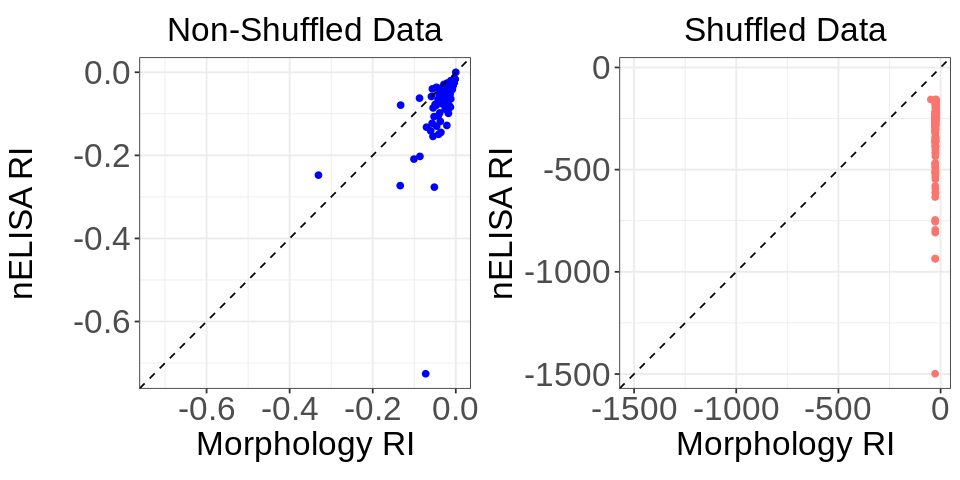

In [13]:
width <- 8
height <- 4
options(repr.plot.width = width, repr.plot.height = height)
# combine the two plots 
RI_plots <- plot_grid(RI_plot_no_shuffle,  RI_plot_inset_shuffle,  label_size = 20, ncol = 2, align = "hv", rel_widths = c(1, 1))
RI_plots

## mAP results

In [14]:
# set path to the data morphology
# class
df_morphology_class_path <- file.path("..","..","..","9.mAP","data","processed","aggregate_mAPs","morphology","mAP_scores_class.csv")
reg_df_morphology_class_path <- file.path("..","..","..","9.mAP","data","processed","mAP_scores","morphology","mAP_scores_regular_class.csv")
shuffled_df_morphology_class_path <- file.path("..","..","..","9.mAP","data","processed","mAP_scores","morphology","mAP_scores_shuffled_class.csv")
shuffled_feature_space_df_morphology_class_path <- file.path("..","..","..","9.mAP","data","processed","mAP_scores","morphology","mAP_scores_shuffled_feature_space_class.csv")
# treatment 
treatment_df_morphology_treatment_path <- file.path("..","..","..","9.mAP","data","processed","aggregate_mAPs","morphology","mAP_scores_treatment.csv")
reg_df_morphology_treatment_path <- file.path("..","..","..","9.mAP","data","processed","mAP_scores","morphology","mAP_scores_regular_treatment.csv")
shuffled_df_morphology_treatment_path <- file.path("..","..","..","9.mAP","data","processed","mAP_scores","morphology","mAP_scores_shuffled_class_treatment.csv")
shuffled_feature_space_df_morphology_treatment_path <- file.path("..","..","..","9.mAP","data","processed","mAP_scores","morphology","mAP_scores_shuffled_feature_space_treatment.csv")

# set path to the secretome data
# class
df_secretome_class_path <- file.path("..","..","..","9.mAP","data","processed","aggregate_mAPs","secretome","mAP_scores_class.csv")
reg_df_secretome_class_path <- file.path("..","..","..","9.mAP","data","processed","mAP_scores","secretome","mAP_scores_regular_class.csv")
shuffled_df_secretome_class_path <- file.path("..","..","..","9.mAP","data","processed","mAP_scores","secretome","mAP_scores_shuffled_class.csv")
shuffled_feature_space_df_secretome_class_path <- file.path("..","..","..","9.mAP","data","processed","mAP_scores","secretome","mAP_scores_shuffled_feature_space_class.csv")
# treatment
treatment_df_secretome_treatment_path <- file.path("..","..","..","9.mAP","data","processed","aggregate_mAPs","secretome","mAP_scores_treatment.csv")
reg_df_secretome_treatment_path <- file.path("..","..","..","9.mAP","data","processed","mAP_scores","secretome","mAP_scores_regular_treatment.csv")
shuffled_df_secretome_treatment_path <- file.path("..","..","..","9.mAP","data","processed","mAP_scores","secretome","mAP_scores_shuffled_treatment.csv")
shuffled_feature_space_df_secretome_treatment_path <- file.path("..","..","..","9.mAP","data","processed","mAP_scores","secretome","mAP_scores_shuffled_feature_space_treatment.csv")

# read in the data
df_morphology_class <- read.csv(df_morphology_class_path)
reg_df_morphology_class <- read.csv(reg_df_morphology_class_path)
shuffled_df_morphology_class <- read.csv(shuffled_df_morphology_class_path)
shuffled_feature_space_df_morphology_class <- read.csv(shuffled_feature_space_df_morphology_class_path)

df_morphology_treatment <- read.csv(treatment_df_morphology_treatment_path)
reg_df_morphology_treatment <- read.csv(reg_df_morphology_treatment_path)
shuffled_df_morphology_treatment <- read.csv(shuffled_df_morphology_treatment_path)
shuffled_feature_space_df_morphology_treatment <- read.csv(shuffled_feature_space_df_morphology_treatment_path)

df_secretome_class <- read.csv(df_secretome_class_path)
reg_df_secretome_class <- read.csv(reg_df_secretome_class_path)
shuffled_df_secretome_class <- read.csv(shuffled_df_secretome_class_path)
shuffled_feature_space_df_secretome_class <- read.csv(shuffled_feature_space_df_secretome_class_path)

df_secretome_treatment <- read.csv(treatment_df_secretome_treatment_path)
reg_df_secretome_treatment <- read.csv(reg_df_secretome_treatment_path)
shuffled_df_secretome_treatment <- read.csv(shuffled_df_secretome_treatment_path)
shuffled_feature_space_df_secretome_treatment <- read.csv(shuffled_feature_space_df_secretome_treatment_path)

In [15]:
levels_list <- c(
    'Media',
    'DMSO_0.100_%_DMSO_0.025_%',
    'DMSO_0.100_%_DMSO_1.000_%',
    'DMSO_0.100_%_Z-VAD-FMK_30.000_uM',
    'DMSO_0.100_%_Z-VAD-FMK_100.000_uM',

    'Disulfiram_0.100_uM_DMSO_0.025_%',
    'Disulfiram_1.000_uM_DMSO_0.025_%',
    'Disulfiram_2.500_uM_DMSO_0.025_%',
    
    'Flagellin_0.100_ug_per_ml_DMSO_0.025_%',
    'Flagellin_1.000_ug_per_ml_DMSO_0.025_%',
    'Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM',
    
    'LPS_0.010_ug_per_ml_DMSO_0.025_%',
    'LPS_0.100_ug_per_ml_DMSO_0.025_%',
    'LPS_1.000_ug_per_ml_DMSO_0.025_%',

    'LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%',
    'LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%',
    'LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%',
    'LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM',
    'LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM',

    'LPS_10.000_ug_per_ml_DMSO_0.025_%',
    'LPS_10.000_ug_per_ml_Disulfiram_0.100_uM',
    'LPS_10.000_ug_per_ml_Disulfiram_1.000_uM',
    'LPS_10.000_ug_per_ml_Disulfiram_2.500_uM',
    'LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM',
    
    'LPS_100.000_ug_per_ml_DMSO_0.025_%',
    'LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%',
    'LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%',
    'LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%',

    'H2O2_100.000_nM_DMSO_0.025_%',
    'H2O2_100.000_uM_DMSO_0.025_%',
    'H2O2_100.000_uM_Disulfiram_1.000_uM',
    'H2O2_100.000_uM_Z-VAD-FMK_100.000_uM',
    'Thapsigargin_1.000_uM_DMSO_0.025_%',
    'Thapsigargin_10.000_uM_DMSO_0.025_%',

    'Topotecan_5.000_nM_DMSO_0.025_%',  
    'Topotecan_10.000_nM_DMSO_0.025_%',
    'Topotecan_20.000_nM_DMSO_0.025_%'
)

## Clean the class data

In [16]:
# declare the shuffled column as a factor
# replace the values in the shuffled column
# declare the shuffled column as a factor
# replace the values in the shuffled column
df_morphology_class$shuffled <- gsub("features_shuffled", "Shuffled features", df_morphology_class$shuffled)
df_morphology_class$shuffled <- gsub("phenotype_shuffled", "Shuffled phenotypes", df_morphology_class$shuffled)
df_morphology_class$shuffled <- gsub("non-shuffled", "Non-shuffled", df_morphology_class$shuffled)
df_morphology_class$shuffled <- factor(df_morphology_class$shuffled, levels = c( "Non-shuffled", "Shuffled features", "Shuffled phenotypes"))
df_morphology_class$Metadata_labels <- factor(df_morphology_class$Metadata_labels, levels = c("Control", "Apoptosis", "Pyroptosis"))

df_secretome_class$shuffled <- gsub("features_shuffled", "Shuffled features", df_secretome_class$shuffled)
df_secretome_class$shuffled <- gsub("phenotype_shuffled", "Shuffled phenotypes", df_secretome_class$shuffled)
df_secretome_class$shuffled <- gsub("non-shuffled", "Non-shuffled", df_secretome_class$shuffled)
df_secretome_class$shuffled <- factor(df_secretome_class$shuffled, levels = c( "Non-shuffled", "Shuffled features", "Shuffled phenotypes"))
df_secretome_class$Metadata_labels <- factor(df_secretome_class$Metadata_labels, levels = c("Control", "Apoptosis", "Pyroptosis"))

df_morphology_treatment$shuffled <- gsub("features_shuffled", "Shuffled features", df_morphology_treatment$shuffled)
df_morphology_treatment$shuffled <- gsub("phenotype_shuffled", "Shuffled phenotypes", df_morphology_treatment$shuffled)
df_morphology_treatment$shuffled <- gsub("non-shuffled", "Non-shuffled", df_morphology_treatment$shuffled)
df_morphology_treatment$shuffled <- factor(df_morphology_treatment$shuffled, levels = c( "Non-shuffled", "Shuffled features", "Shuffled phenotypes"))
df_morphology_treatment$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- factor(df_morphology_treatment$oneb_Metadata_Treatment_Dose_Inhibitor_Dose, levels = levels_list)

df_secretome_treatment$shuffled <- gsub("features_shuffled", "Shuffled features", df_secretome_treatment$shuffled)
df_secretome_treatment$shuffled <- gsub("phenotype_shuffled", "Shuffled phenotypes", df_secretome_treatment$shuffled)
df_secretome_treatment$shuffled <- gsub("non-shuffled", "Non-shuffled", df_secretome_treatment$shuffled)
df_secretome_treatment$shuffled <- factor(df_secretome_treatment$shuffled, levels = c( "Non-shuffled", "Shuffled features", "Shuffled phenotypes"))
df_secretome_treatment$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- factor(df_secretome_treatment$oneb_Metadata_Treatment_Dose_Inhibitor_Dose, levels = levels_list)


## Clean the single well data

In [17]:
# combine the dataframes
all_df_morphology_class <- rbind(reg_df_morphology_class, shuffled_df_morphology_class, shuffled_feature_space_df_morphology_class)
all_df_morphology_treatment <- rbind(reg_df_morphology_treatment, shuffled_df_morphology_treatment, shuffled_feature_space_df_morphology_treatment)
all_df_secretome_class <- rbind(reg_df_secretome_class, shuffled_df_secretome_class, shuffled_feature_space_df_secretome_class)
all_df_secretome_treatment <- rbind(reg_df_secretome_treatment, shuffled_df_secretome_treatment, shuffled_feature_space_df_secretome_treatment)

all_df_morphology_class$shuffled <- gsub("features_shuffled", "Shuffled features", all_df_morphology_class$shuffled)
all_df_morphology_class$shuffled <- gsub("phenotype_shuffled", "Shuffled phenotypes", all_df_morphology_class$shuffled)
all_df_morphology_class$shuffled <- gsub("non-shuffled", "Non-shuffled", all_df_morphology_class$shuffled)
all_df_morphology_class$shuffled <- factor(all_df_morphology_class$shuffled, levels = c( "Non-shuffled", "Shuffled features", "Shuffled phenotypes"))
all_df_morphology_class$Metadata_labels <- factor(all_df_morphology_class$Metadata_labels, levels = c("Control", "Apoptosis", "Pyroptosis"))

all_df_secretome_class$shuffled <- gsub("features_shuffled", "Shuffled features", all_df_secretome_class$shuffled)
all_df_secretome_class$shuffled <- gsub("phenotype_shuffled", "Shuffled phenotypes", all_df_secretome_class$shuffled)
all_df_secretome_class$shuffled <- gsub("non-shuffled", "Non-shuffled", all_df_secretome_class$shuffled)
all_df_secretome_class$shuffled <- factor(all_df_secretome_class$shuffled, levels = c( "Non-shuffled", "Shuffled features", "Shuffled phenotypes"))

all_df_morphology_treatment$shuffled <- gsub("features_shuffled", "Shuffled features", all_df_morphology_treatment$shuffled)
all_df_morphology_treatment$shuffled <- gsub("phenotype_shuffled", "Shuffled phenotypes", all_df_morphology_treatment$shuffled)
all_df_morphology_treatment$shuffled <- gsub("non-shuffled", "Non-shuffled", all_df_morphology_treatment$shuffled)
all_df_morphology_treatment$shuffled <- factor(all_df_morphology_treatment$shuffled, levels = c( "Non-shuffled", "Shuffled features", "Shuffled phenotypes"))
all_df_morphology_treatment$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- factor(all_df_morphology_treatment$oneb_Metadata_Treatment_Dose_Inhibitor_Dose, levels = levels_list)

all_df_secretome_treatment$shuffled <- gsub("features_shuffled", "Shuffled features", all_df_secretome_treatment$shuffled)
all_df_secretome_treatment$shuffled <- gsub("phenotype_shuffled", "Shuffled phenotypes", all_df_secretome_treatment$shuffled)
all_df_secretome_treatment$shuffled <- gsub("non-shuffled", "Non-shuffled", all_df_secretome_treatment$shuffled)
all_df_secretome_treatment$shuffled <- factor(all_df_secretome_treatment$shuffled, levels = c( "Non-shuffled", "Shuffled features", "Shuffled phenotypes"))
all_df_secretome_treatment$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- factor(all_df_secretome_treatment$oneb_Metadata_Treatment_Dose_Inhibitor_Dose, levels = levels_list)

## mAP Scatter compare plot

In [18]:
# cobine the dfs
# get the average precision, shuffled, and Metadata_labels columns by name
subset_morphology_class <- all_df_morphology_class[,c("average_precision", "shuffled", "Metadata_labels")]
# rename the average_precision column to moprhology_ap
colnames(subset_morphology_class)[colnames(subset_morphology_class)=="average_precision"] <- "morphology_ap"

# get the average precision, shuffled, and Metadata_labels columns by name
subset_secretome_class <- all_df_secretome_class[,c("average_precision", "shuffled", "Metadata_labels")]
# rename the average_precision column to secretome_ap
colnames(subset_secretome_class)[colnames(subset_secretome_class)=="average_precision"] <- "secretome_ap"

# merge the dataframes
merged_df <- merge(subset_morphology_class, subset_secretome_class, by=c("shuffled", "Metadata_labels"))
head(merged_df)



,shuffled,Metadata_labels,morphology_ap,secretome_ap
,<fct>,<fct>,<dbl>,<dbl>
1,Non-shuffled,Apoptosis,0.8179272,1.0000000
2,Non-shuffled,Apoptosis,0.8179272,1.0000000
3,Non-shuffled,Apoptosis,0.8179272,1.0000000
4,Non-shuffled,Apoptosis,0.8179272,0.5312370
5,Non-shuffled,Apoptosis,0.8179272,0.5412353
6,Non-shuffled,Apoptosis,0.8179272,0.9821429


In [19]:
# aggregate the data by shuffled and Metadata_labels
merged_agg <- aggregate(. ~ shuffled + Metadata_labels, data=merged_df, FUN=mean)
# combine the shuffled and Metadata_labels columns
merged_agg$group <- paste(merged_agg$shuffled, merged_agg$Metadata_labels, sep="_")
# change the text in the group column
merged_agg$group <- gsub("Non-shuffled_Control", "Non-shuffled\nControl", merged_agg$group)
merged_agg$group <- gsub("Shuffled features_Control", "Shuffled features\nControl", merged_agg$group)
merged_agg$group <- gsub("Shuffled phenotypes_Control", "Shuffled phenotypes\nControl", merged_agg$group)
merged_agg$group <- gsub("Non-shuffled_Apoptosis", "Non-shuffled\nApoptosis", merged_agg$group)
merged_agg$group <- gsub("Shuffled features_Apoptosis", "Shuffled features\nApoptosis", merged_agg$group)
merged_agg$group <- gsub("Shuffled phenotypes_Apoptosis", "Shuffled phenotypes\nApoptosis", merged_agg$group)
merged_agg$group <- gsub("Non-shuffled_Pyroptosis", "Non-shuffled\nPyroptosis", merged_agg$group)
merged_agg$group <- gsub("Shuffled features_Pyroptosis", "Shuffled features\nPyroptosis", merged_agg$group)
merged_agg$group <- gsub("Shuffled phenotypes_Pyroptosis", "Shuffled phenotypes\nPyroptosis", merged_agg$group)
# make the group column a factor
merged_agg$group <- factor(
    merged_agg$group, 
    levels = c(
        "Non-shuffled\nControl", 
        "Shuffled features\nControl", 
        "Shuffled phenotypes\nControl", 

        "Non-shuffled\nApoptosis", 
        "Shuffled features\nApoptosis", 
        "Shuffled phenotypes\nApoptosis",
        
        "Non-shuffled\nPyroptosis",
        "Shuffled features\nPyroptosis", 
        "Shuffled phenotypes\nPyroptosis"))

merged_agg

shuffled,Metadata_labels,morphology_ap,secretome_ap,group
<fct>,<fct>,<dbl>,<dbl>,<fct>
Non-shuffled,Control,0.60331815,0.92054275,Non-shuffled Control
Shuffled features,Control,0.53048307,0.53934226,Shuffled features Control
Shuffled phenotypes,Control,0.51707189,0.52678343,Shuffled phenotypes Control
Non-shuffled,Apoptosis,0.64044601,0.73152095,Non-shuffled Apoptosis
Shuffled features,Apoptosis,0.05948675,0.11632370,Shuffled features Apoptosis
Shuffled phenotypes,Apoptosis,0.08938349,0.07780334,Shuffled phenotypes Apoptosis
Non-shuffled,Pyroptosis,0.65299176,0.86662587,Non-shuffled Pyroptosis
Shuffled features,Pyroptosis,0.44293609,0.45922994,Shuffled features Pyroptosis
Shuffled phenotypes,Pyroptosis,0.44856035,0.43906012,Shuffled phenotypes Pyroptosis


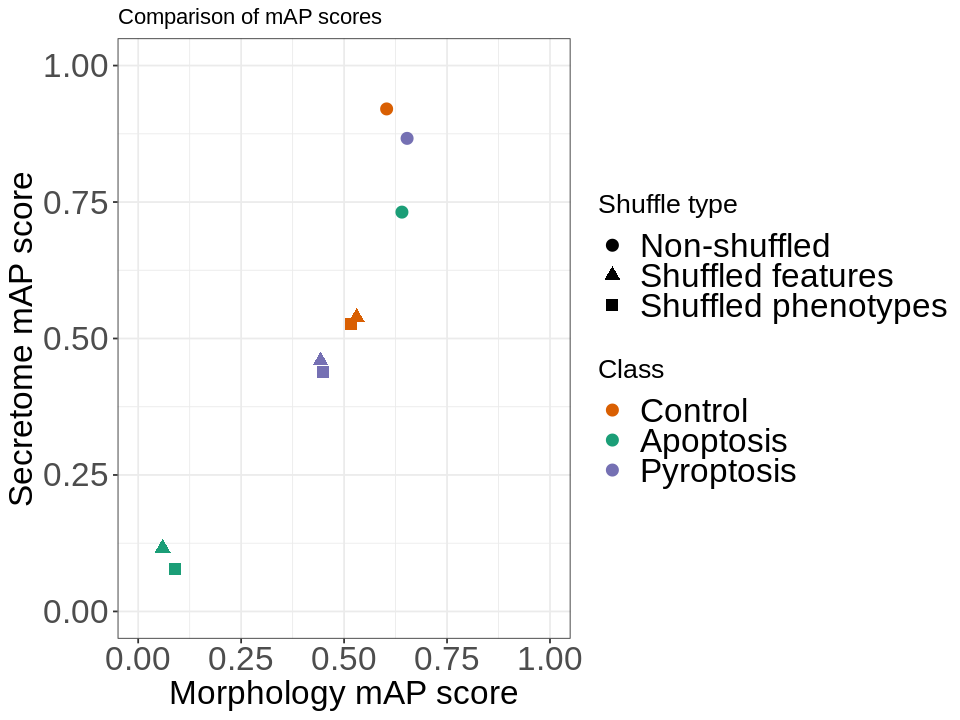

In [20]:
width <- 8
height <- 6
options(repr.plot.width=width, repr.plot.height=height)
# plot the data
scatter_compare <- (
    ggplot(merged_agg, aes(x=morphology_ap, y=secretome_ap, col = Metadata_labels, shape=shuffled))
    + geom_point(size=3, alpha=1)
    + labs(x="Morphology mAP score", y="Secretome mAP score")
    + theme_bw()
    + ggtitle("Comparison of mAP scores")
    + ylim(0,1)
    + xlim(0,1)
    # Change the legend title
    # change the legend shape
    + scale_shape_manual(
        name="Shuffle type",
        labels=c(
            "Non-shuffled", 
            "Shuffled features", 
            "Shuffled phenotypes"
        ),
        values=c(19, 17, 15)
    )
    + scale_color_manual(
        name="Class",
        labels=c(
            "Control", 
            "Apoptosis", 
            "Pyroptosis"
        ),
        values=c(
            brewer.pal(3, "Dark2")[2],
            brewer.pal(3, "Dark2")[1],
            brewer.pal(3, "Dark2")[3]
    )
)
    + figure_theme

)
scatter_compare

## mAP Scatter compare plot treatemnts


In [21]:
# cobine the dfs
# get the average precision, shuffled, and Metadata_labels columns by name
subset_morphology_treatment <- all_df_morphology_treatment[,c("average_precision", "shuffled", "Metadata_labels","oneb_Metadata_Treatment_Dose_Inhibitor_Dose")]
# rename the average_precision column to moprhology_ap
colnames(subset_morphology_treatment)[colnames(subset_morphology_treatment)=="average_precision"] <- "morphology_ap"

# get the average precision, shuffled, and Metadata_labels columns by name
subset_secretome_treatment <- all_df_secretome_treatment[,c("average_precision", "shuffled", "Metadata_labels","oneb_Metadata_Treatment_Dose_Inhibitor_Dose")]
# rename the average_precision column to secretome_ap
colnames(subset_secretome_treatment)[colnames(subset_secretome_treatment)=="average_precision"] <- "secretome_ap"

# merge the dataframes
merged_df <- merge(subset_morphology_treatment, subset_secretome_treatment, by=c("shuffled", "Metadata_labels", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"))
head(merged_df)



,shuffled,Metadata_labels,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,morphology_ap,secretome_ap
,<fct>,<chr>,<fct>,<dbl>,<dbl>
1,Non-shuffled,Apoptosis,Thapsigargin_1.000_uM_DMSO_0.025_%,0.5643275,0.5555556
2,Non-shuffled,Apoptosis,Thapsigargin_1.000_uM_DMSO_0.025_%,0.5643275,0.5500000
3,Non-shuffled,Apoptosis,Thapsigargin_1.000_uM_DMSO_0.025_%,0.5643275,1.0000000
4,Non-shuffled,Apoptosis,Thapsigargin_1.000_uM_DMSO_0.025_%,0.5643275,0.8333333
5,Non-shuffled,Apoptosis,Thapsigargin_1.000_uM_DMSO_0.025_%,0.5084034,0.5555556
6,Non-shuffled,Apoptosis,Thapsigargin_1.000_uM_DMSO_0.025_%,0.5084034,0.5500000


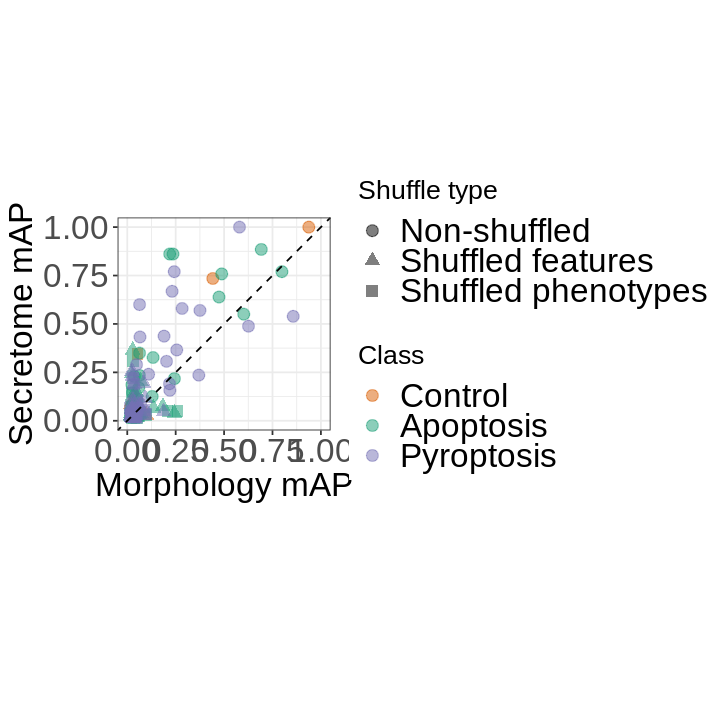

In [22]:
height <- 6
width <- 6
options(repr.plot.width=width, repr.plot.height=height)
# aggregate the data by shuffled and oneb_Metadata_Treatment_Dose_Inhibitor_Dose and shuffled
merged_agg <- aggregate(. ~ shuffled + oneb_Metadata_Treatment_Dose_Inhibitor_Dose + Metadata_labels, data=merged_df, FUN=mean)
# scatter plot
scatter_compare_treatment <- (
    ggplot(merged_agg, aes(x=morphology_ap, y=secretome_ap, col = Metadata_labels, shape=shuffled))
    + geom_point(size=3, alpha=0.5)
    + labs(x="Morphology mAP", y="Secretome mAP")
    + theme_bw()
    + ylim(0,1)
    + xlim(0,1)
    + geom_abline(intercept = 0, slope = 1, linetype="dashed", color="black")
    + figure_theme
    # Change the legend title
    # change the legend shape
    + scale_shape_manual(
        name="Shuffle type",
        labels=c(
            "Non-shuffled", 
            "Shuffled features", 
            "Shuffled phenotypes"
        ),
        values=c(19, 17, 15)
    )
    + scale_color_manual(
        name="Class",
        labels=c(
            "Control", 
            "Apoptosis", 
            "Pyroptosis"
        ),
        values=c(
            brewer.pal(3, "Dark2")[2],
            brewer.pal(3, "Dark2")[1],
            brewer.pal(3, "Dark2")[3]
    )
)
    + figure_theme
    + ggplot2::coord_fixed()

)
scatter_compare_treatment 

In [23]:
head(merged_agg)

,shuffled,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,Metadata_labels,morphology_ap,secretome_ap
,<fct>,<fct>,<chr>,<dbl>,<dbl>
1,Shuffled features,LPS_1.000_ug_per_ml_DMSO_0.025_%,Apoptosis,0.04564596,0.04779082
2,Shuffled phenotypes,LPS_1.000_ug_per_ml_DMSO_0.025_%,Apoptosis,0.04071902,0.01784351
3,Shuffled features,LPS_10.000_ug_per_ml_DMSO_0.025_%,Apoptosis,0.01892518,0.08687019
4,Shuffled phenotypes,LPS_10.000_ug_per_ml_DMSO_0.025_%,Apoptosis,0.04192804,0.02853336
5,Shuffled features,LPS_10.000_ug_per_ml_Disulfiram_1.000_uM,Apoptosis,0.02283066,0.09946360
6,Shuffled phenotypes,LPS_10.000_ug_per_ml_Disulfiram_1.000_uM,Apoptosis,0.01684913,0.02647027


In [24]:
merged_df <- merged_df %>%
    mutate(oneb_Metadata_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_0.025_%' ~ "DMSO 0.1% - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_1.000_%' ~ "DMSO 0.1% - DMSO 1.0%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_100.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_30.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 30.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM' ~ "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.0%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_0.100_uM_DMSO_0.025_%' ~ "Disulfiram 0.1 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_1.000_uM_DMSO_0.025_%' ~ "Disulfiram 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_10.000_nM_DMSO_0.025_%' ~ "Topotecan 10.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_0.100_uM' ~ "LPS 10.0 ug/ml - Disulfiram 0.1 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_1.000_uM' ~ "LPS 10.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_2.500_uM' ~ "LPS 10.0 ug/ml - Disulfiram 2.5 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM' ~ "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Disulfiram_1.000_uM' ~ "H2O2 100.0 uM - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Z-VAD-FMK_100.000_uM' ~ "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_2.500_uM_DMSO_0.025_%' ~ "Disulfiram 2.5 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_20.000_nM_DMSO_0.025_%' ~ "Topotecan 20.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_5.000_nM_DMSO_0.025_%' ~ "Topotecan 5.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='media_ctr_0.0_0_Media_ctr_0.0_0' ~ "Media ctr 0.0 0",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='media_ctr_0.0_0_Media_0.0_0' ~ "Media ctr 0.0 0"
    ))
    # replace Media ctr 0.0 0 with Media
merged_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- gsub("Media ctr 0.0 0", "Media", merged_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)

# split the oneb_Metadata_Treatment_Dose_Inhibitor_Dose into two columns by the " - " delimiter
merged_df <- merged_df %>%
    separate(oneb_Metadata_Treatment_Dose_Inhibitor_Dose, c("inducer", "inhibitor"), sep = " - ", remove = FALSE)

unique(merged_df$inducer)
# replace the inhibitor NA with Media
merged_df$inhibitor <- ifelse(is.na(merged_df$inhibitor), "Media", merged_df$inhibitor)
unique(merged_df$inhibitor)

# make the group_treatment column a factor
merged_df$inducer <- factor(
    merged_df$inducer,
    levels = c(
        'Media',
        'DMSO 0.1%',

        'Flagellin 0.1 ug/ml',
        'Flagellin 1.0 ug/ml',

        'LPS 0.01 ug/ml',
        'LPS 0.1 ug/ml',
        'LPS 1.0 ug/ml',
        'LPS 10.0 ug/ml',
        'LPS 100.0 ug/ml',

        'LPS 1.0 ug/ml + Nigericin 1.0 uM',
        'LPS 1.0 ug/ml + Nigericin 3.0 uM',
        'LPS 1.0 ug/ml + Nigericin 10.0 uM',

        'LPS 100.0 ug/ml + Nigericin 1.0 uM',
        'LPS 100.0 ug/ml + Nigericin 3.0 uM',
        'LPS 100.0 ug/ml + Nigericin 10.0 uM',

        'H2O2 100.0 nM',
        'H2O2 100.0 uM',

        'Disulfiram 0.1 uM',
        'Disulfiram 1.0 uM',
        'Disulfiram 2.5 uM',

        'Thapsigargin 1.0 uM',
        'Thapsigargin 10.0 uM',

        'Topotecan 5.0 nM',
        'Topotecan 10.0 nM',
        'Topotecan 20.0 nM'
    )
)

# make the group_treatment column a factor
merged_df$inhibitor <- factor(
    merged_df$inhibitor,
    levels = c(
        'Media',
        'DMSO 0.025%',
        'DMSO 1.0%',

        'Disulfiram 0.1 uM',
        'Disulfiram 1.0 uM',
        'Disulfiram 2.5 uM',

        'Z-VAD-FMK 30.0 uM',
        'Z-VAD-FMK 100.0 uM'
    )
)
head(merged_df)

[1] "Thapsigargin 1.0 uM"                 "Thapsigargin 10.0 uM"               
 [3] "Disulfiram 0.1 uM"                   "Disulfiram 1.0 uM"                  
 [5] "Disulfiram 2.5 uM"                   "DMSO 0.1%"                          
 [7] "Flagellin 0.1 ug/ml"                 "H2O2 100.0 nM"                      
 [9] "H2O2 100.0 uM"                       "LPS 10.0 ug/ml"                     
[11] "LPS 1.0 ug/ml + Nigericin 10.0 uM"   NA                                   
[13] "Topotecan 10.0 nM"                   "Topotecan 20.0 nM"                  
[15] "Topotecan 5.0 nM"                    "Flagellin 1.0 ug/ml"                
[17] "LPS 0.01 ug/ml"                      "LPS 0.1 ug/ml"                      
[19] "LPS 1.0 ug/ml"                       "LPS 100.0 ug/ml"                    
[21] "LPS 1.0 ug/ml + Nigericin 1.0 uM"    "LPS 1.0 ug/ml + Nigericin 3.0 uM"   
[23] "LPS 100.0 ug/ml + Nigericin 1.0 uM"  "LPS 100.0 ug/ml + Nigericin 10.0 uM"
[25] "LPS 100.0 ug/ml + Nigericin 3.0 uM"

[1] "DMSO 0.025%"        "DMSO 1.0%"          "Z-VAD-FMK 100.0 uM"
[4] "Z-VAD-FMK 30.0 uM"  "Disulfiram 1.0 uM"  "Media"             
[7] "Disulfiram 0.1 uM"  "Disulfiram 2.5 uM"

,shuffled,Metadata_labels,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,inducer,inhibitor,morphology_ap,secretome_ap
,<fct>,<chr>,<chr>,<fct>,<fct>,<dbl>,<dbl>
1,Non-shuffled,Apoptosis,Thapsigargin 1.0 uM - DMSO 0.025%,Thapsigargin 1.0 uM,DMSO 0.025%,0.5643275,0.5555556
2,Non-shuffled,Apoptosis,Thapsigargin 1.0 uM - DMSO 0.025%,Thapsigargin 1.0 uM,DMSO 0.025%,0.5643275,0.5500000
3,Non-shuffled,Apoptosis,Thapsigargin 1.0 uM - DMSO 0.025%,Thapsigargin 1.0 uM,DMSO 0.025%,0.5643275,1.0000000
4,Non-shuffled,Apoptosis,Thapsigargin 1.0 uM - DMSO 0.025%,Thapsigargin 1.0 uM,DMSO 0.025%,0.5643275,0.8333333
5,Non-shuffled,Apoptosis,Thapsigargin 1.0 uM - DMSO 0.025%,Thapsigargin 1.0 uM,DMSO 0.025%,0.5084034,0.5555556
6,Non-shuffled,Apoptosis,Thapsigargin 1.0 uM - DMSO 0.025%,Thapsigargin 1.0 uM,DMSO 0.025%,0.5084034,0.5500000


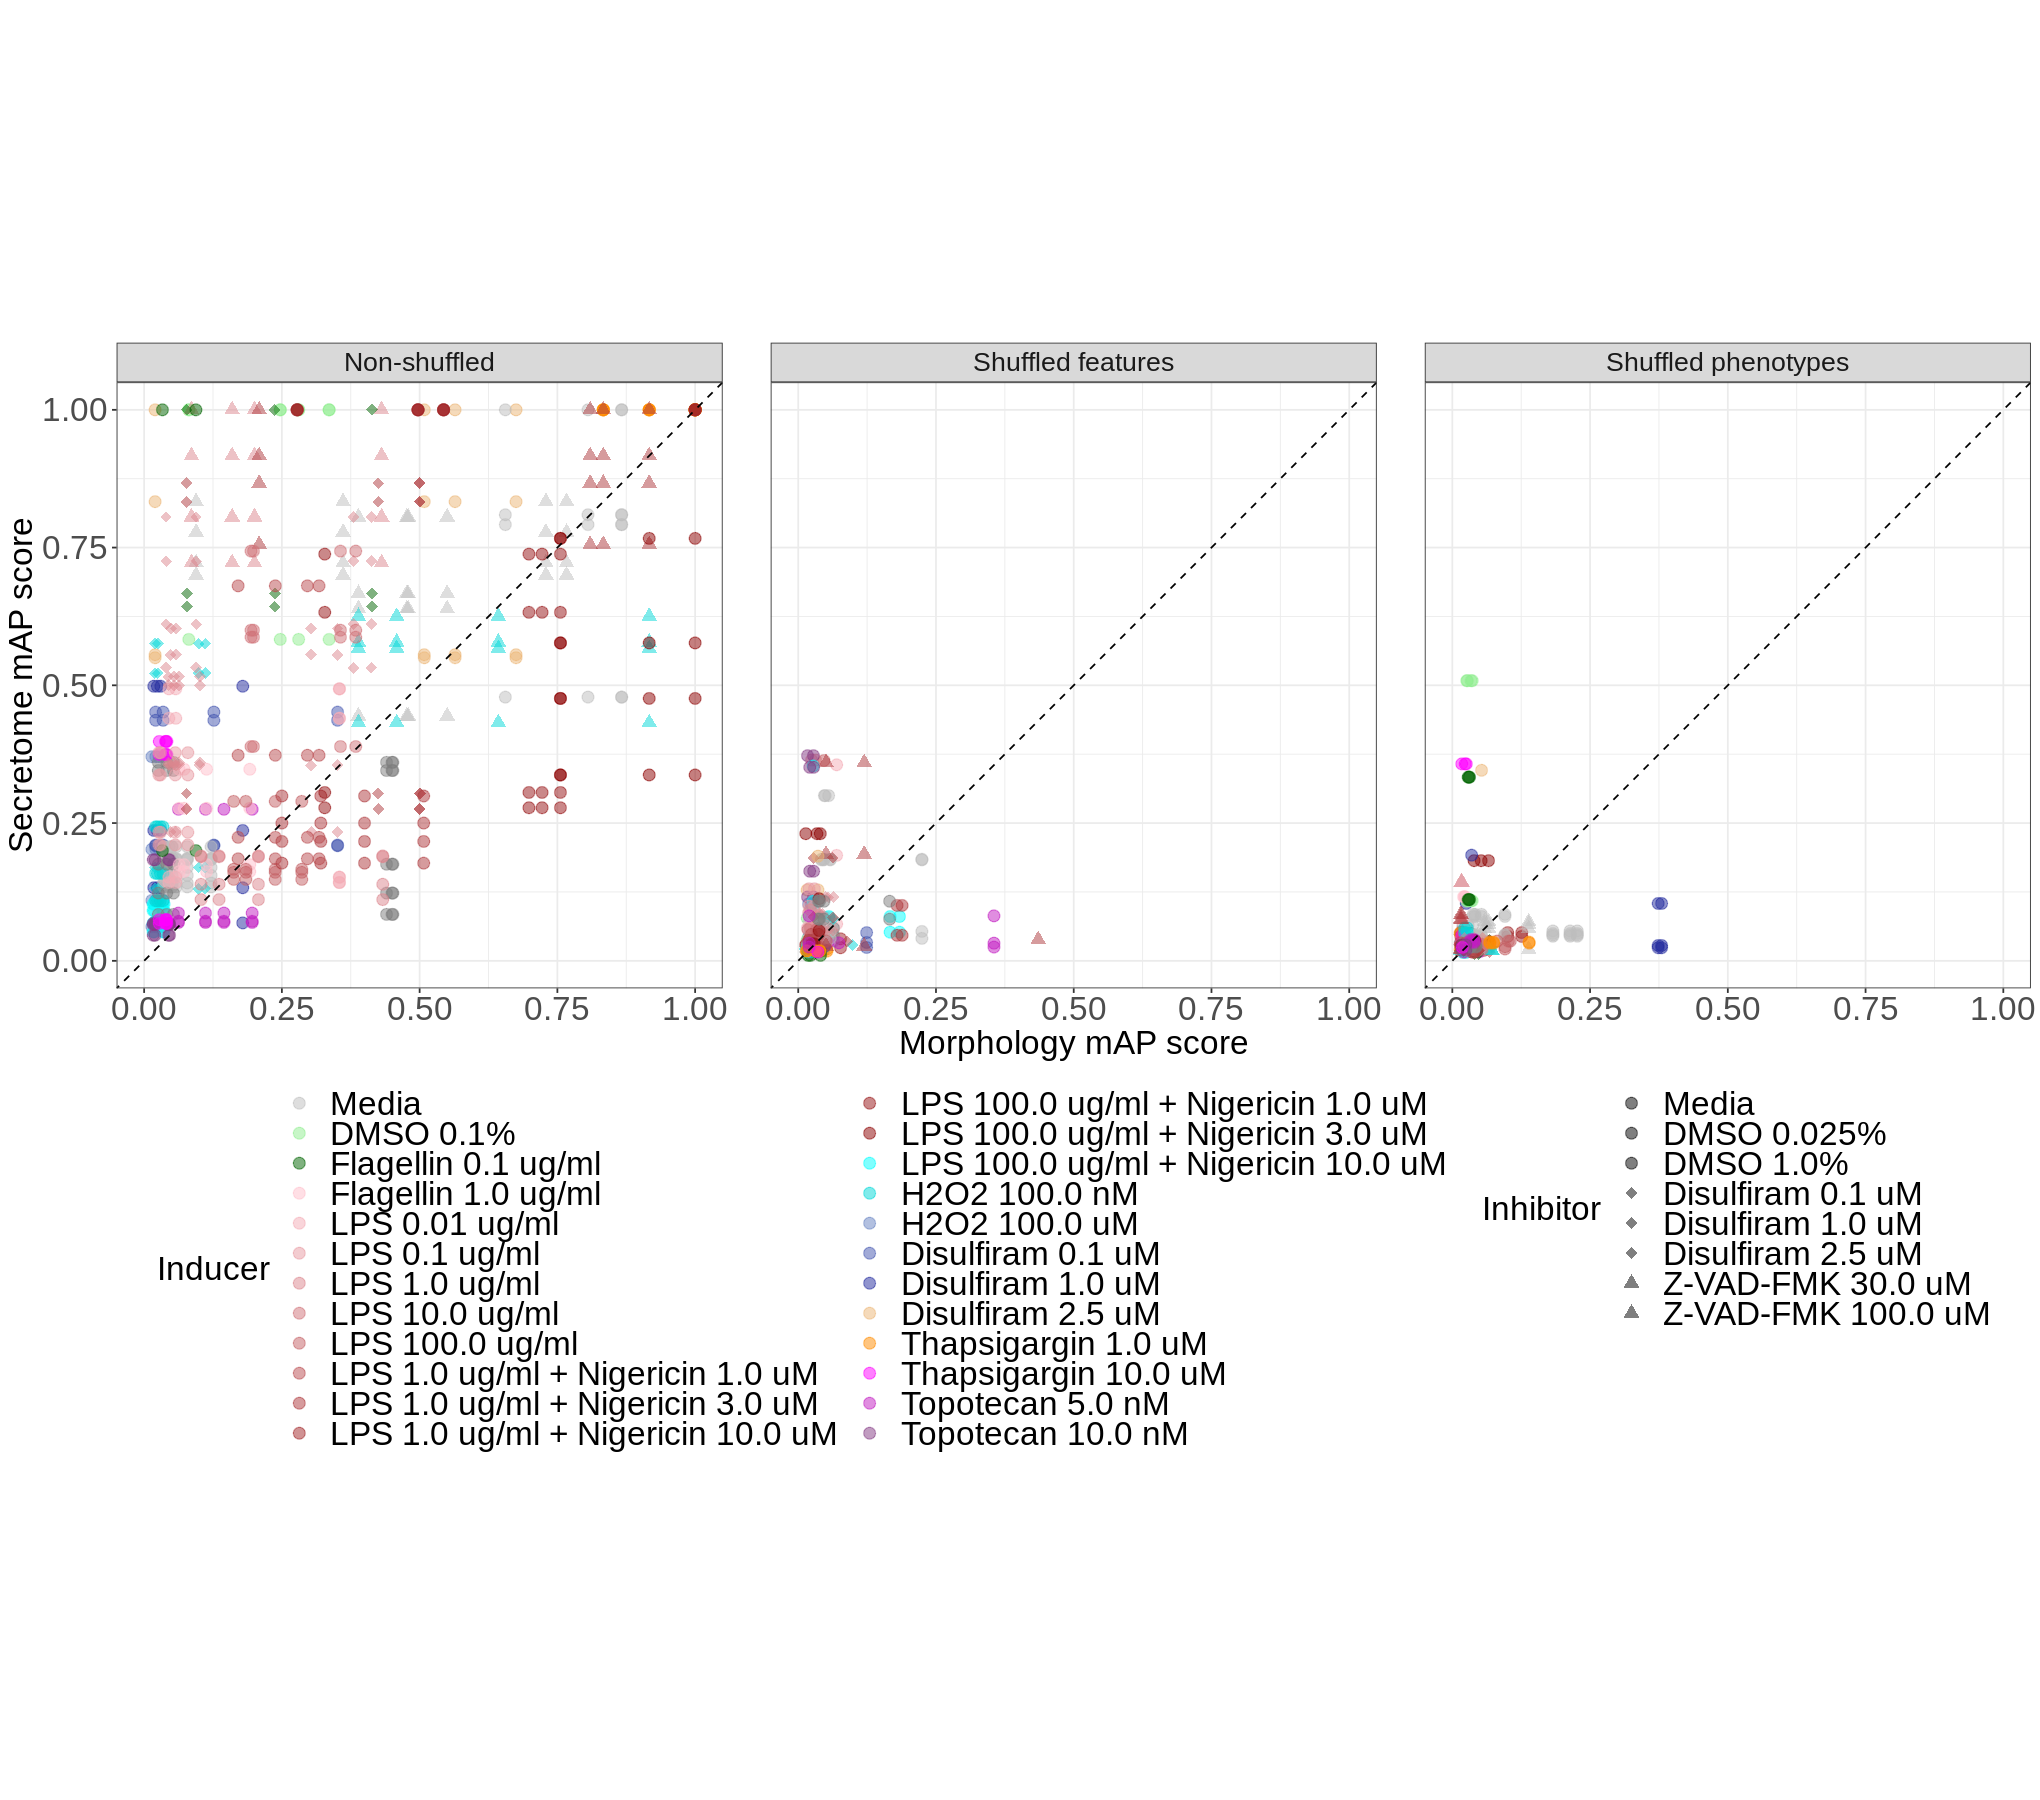

In [25]:
width <- 17
height <- 15
options(repr.plot.width=width, repr.plot.height=height)
# scatter plot with fill being the treatment dose
scatter_by_treatment <- (
    ggplot(merged_df, aes(x=morphology_ap, y=secretome_ap, col = inducer, shape=inhibitor))
    + geom_point(size=3, alpha=0.5)
    + labs(x="Morphology mAP score", y="Secretome mAP score")
    + theme_bw()
    + ylim(0,1)
    + xlim(0,1)
    + figure_theme
    # add line 
    + geom_abline(intercept = 0, slope = 1, linetype="dashed", color="black")
    # Change the legend title
    # change the legend shape
    + scale_color_manual(
        name = "Inducer",
        labels = c(
            'Media',
            'DMSO 0.1%',

            'Flagellin 0.1 ug/ml',
            'Flagellin 1.0 ug/ml',

            'LPS 0.01 ug/ml',
            'LPS 0.1 ug/ml',
            'LPS 1.0 ug/ml',
            'LPS 10.0 ug/ml',
            'LPS 100.0 ug/ml',

            'LPS 1.0 ug/ml + Nigericin 1.0 uM',
            'LPS 1.0 ug/ml + Nigericin 3.0 uM',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM',

            'LPS 100.0 ug/ml + Nigericin 1.0 uM',
            'LPS 100.0 ug/ml + Nigericin 3.0 uM',
            'LPS 100.0 ug/ml + Nigericin 10.0 uM',

            'H2O2 100.0 nM',
            'H2O2 100.0 uM',

            'Disulfiram 0.1 uM',
            'Disulfiram 1.0 uM',
            'Disulfiram 2.5 uM',

            'Thapsigargin 1.0 uM',
            'Thapsigargin 10.0 uM',

            'Topotecan 5.0 nM',
            'Topotecan 10.0 nM',
            'Topotecan 20.0 nM'
        ),
        values = colors)
    + scale_shape_manual(
        name = "Inhibitor",
        labels = c(
            'Media',
            'DMSO 0.025%',
            'DMSO 1.0%',

            'Disulfiram 0.1 uM',
            'Disulfiram 1.0 uM',
            'Disulfiram 2.5 uM',

            'Z-VAD-FMK 30.0 uM',
            'Z-VAD-FMK 100.0 uM'

        ),
        values = shapes
    )
    # make the legend 1 column
    
    + ggplot2::coord_fixed()
    + facet_grid(.~shuffled)
    # set spacing between the facets
    + theme(panel.spacing = unit(2, "lines"))
    # move legend to the bottom
    + theme(legend.position = "bottom")
    + guides(color = guide_legend(ncol = 2), shape = guide_legend(ncol = 1))
    # make legend title larger
    + theme(legend.title = element_text(size=20))
    


)
scatter_by_treatment

## Patch the plots together

In [26]:
RI <- (
    RI_plot_no_shuffle
    + RI_plot_inset_shuffle
)
# as ggplot object
library(ggplotify)
RI <- as.ggplot(RI)

Warning message:
“package ‘ggplotify’ was built under R version 4.2.3”


png 
  2

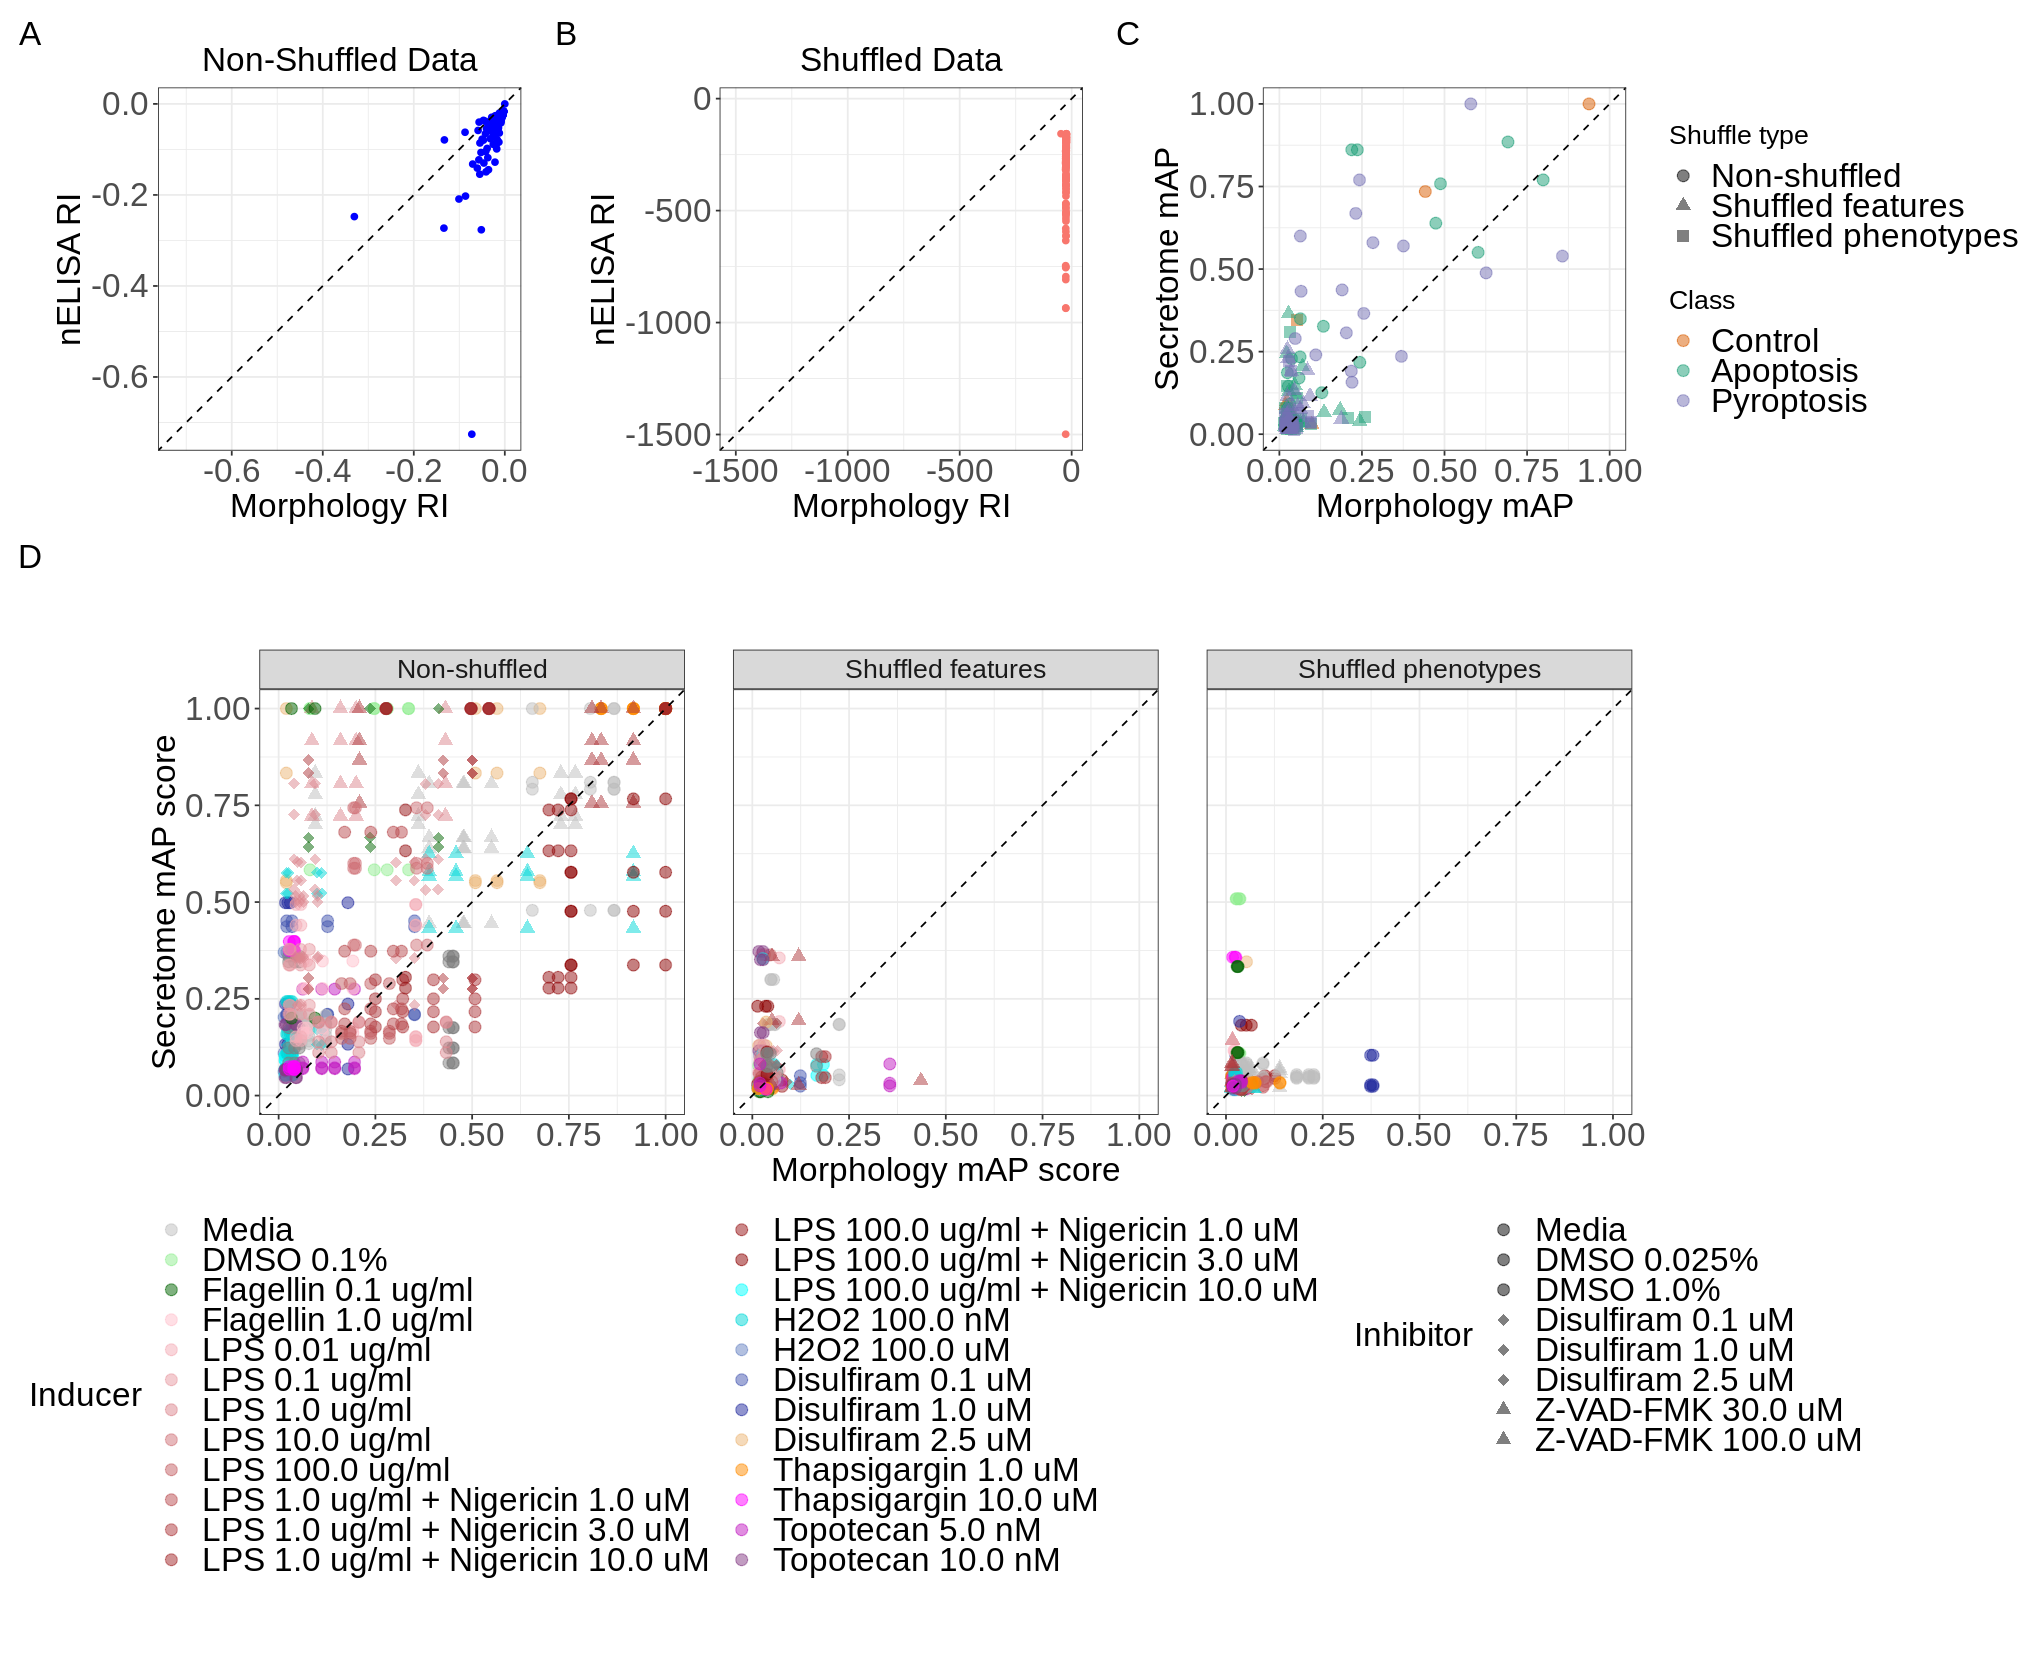

In [27]:
width <- 17
height <- 14
options(repr.plot.width = width, repr.plot.height = height)

layout <- c(
    area(t=1, b=2, l=1, r=2), # A
    area(t=1, b=2, l=3, r=4), # B
    area(t=1, b=2, l=5, r=6), # C
    area(t=3, b=5, l=1, r=6) # D
)


figure <- (
    RI_plot_no_shuffle
    + RI_plot_inset_shuffle
    + scatter_compare_treatment
    # move the plot left a bit
    + wrap_elements(scatter_by_treatment)
    + plot_layout(design = layout, heights = c(1, 0.5, 3))
    + plot_annotation(tag_levels = "A")  & theme(plot.tag = element_text(size = 20))

)
png(filename = file.path(paste0(
    "../", 
    "figures/",
    cell_type,
    "S10.png")), width = width, height = height, units = "in", res = 600
)
figure
dev.off()
figure


In [28]:
print(paste0(
    "non-shuffled: f(x) = ", 
    round(non_shuffled_slope, 2),
    "x + ",
    round(non_shuffled_intercept, 2),
    " + epsilon"
))

print(paste0(
    "shuffled: f(x) = ", 
    round(shuffled_slope, 2),
    "x + ",
    round(shuffled_intercept, 2),
    " + epsilon"
))

[1] "non-shuffled: f(x) = 1.2x + -0.03 + epsilon"
[1] "shuffled: f(x) = 18.02x + 136.95 + epsilon"
